In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2 as cv
import math
from PIL import Image, ImageDraw, ImageFont, ImageColor

## Let's try it!

### Image preprocessing

In [2]:
#img_path = "/home/thierry/code/zuzannaszu/chess_hacker/Raw_Data/data/1.jpg"
img_path = "/home/thierry/code/zuzannaszu/chess_hacker/Raw_Data/new_chess_data/boards/board1.jpeg"
img = cv.imread(img_path)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

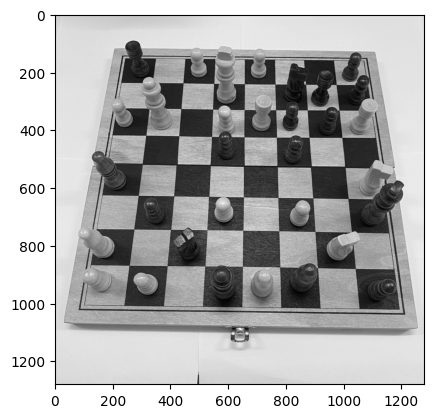

In [3]:
plt.imshow(img_gray,cmap="gray")

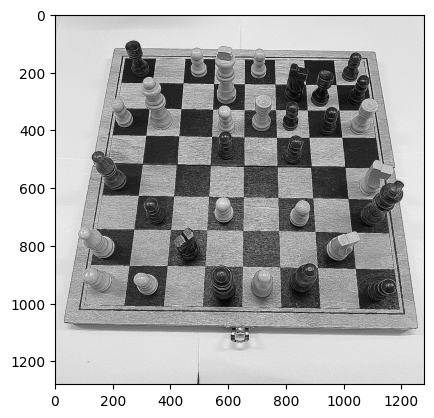

In [4]:
kernel = np.ones((5, 5), np.uint8)
kernel_sharp = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img_sharp = cv.filter2D(img_gray, -1, kernel_sharp)

#img_erosion = cv.erode(blur, kernel, iterations=4)
#img_dilation = cv.dilate(blur, kernel, iterations=3)

plt.imshow(img_sharp, cmap="gray")

### Processing and corners

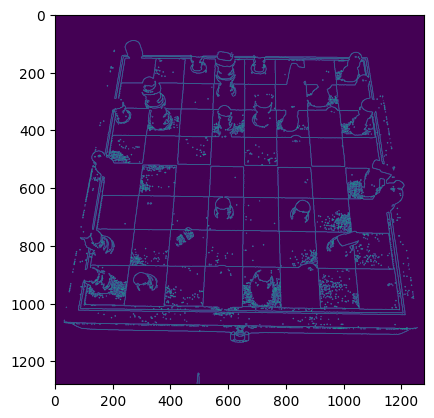

In [5]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
v = np.median(img)
thres = cv.threshold(img_gray,140,255,cv.THRESH_BINARY)
blur = cv.blur(img_gray,(3,3),0)
edges = cv.Canny(thres[1], 140, 400) #70,250 for old
plt.imshow(edges)

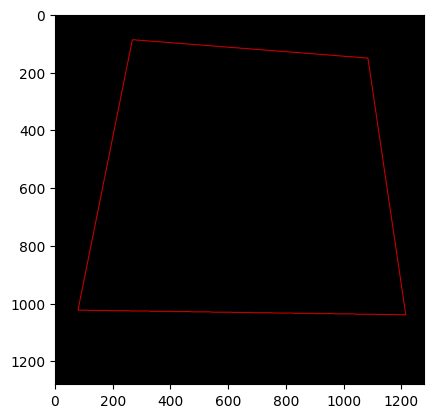

In [6]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_black = np.zeros((1280, 1280, 3), dtype = np.uint8)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
dilated = cv.dilate(edges, kernel, iterations=2)

contours, hierarchy = cv.findContours(dilated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

for idx, contour in enumerate (contours):
    # Approximate the contour shape to a polygon
    peri = cv.arcLength(contour, True)
    if peri > 2500:
        polygon = cv.approxPolyDP(contour, epsilon=0.05*cv.arcLength(contour, True), closed=False)
        sides = len(polygon)
        if sides == 3:
            pass
            #cv.drawContours(img_black, [polygon], 0, (0, 255, 0), 2)
        elif sides == 4:
            cv.drawContours(img_black, [polygon], 0, (0, 0, 255), 2)
        else:
            real_one = idx
            cv.drawContours(img_black, [polygon], 0, (255, 0, 0), 2)
plt.imshow(img_black)

4


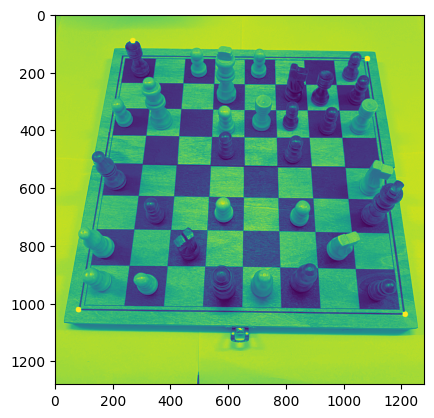

In [7]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_gray_b = cv.cvtColor(img_black, cv.COLOR_BGR2GRAY)
corners = cv.goodFeaturesToTrack(img_gray_b, 4, 0.4, 600)
corners = np.int0(corners)
point_corners = []
for corner in corners:
    x, y = corner.ravel()
    cv.circle(img_gray, (x,y), 10, 255, -1)
    point_corners.append([x,y])
print(len(point_corners))
point_corners = sorted(point_corners)
plt.imshow(img_gray)

In [8]:
pts = np.array(point_corners)
center = np.mean(pts, axis=0)

# Sort the points in clockwise
cyclic_pts = [
        # Top-left
        pts[np.where(np.logical_and(pts[:, 0] < center[0], pts[:, 1] < center[1]))[0][0], :],
        # Top-right
        pts[np.where(np.logical_and(pts[:, 0] > center[0], pts[:, 1] < center[1]))[0][0], :],
        # Bottom-Right
        pts[np.where(np.logical_and(pts[:, 0] > center[0], pts[:, 1] > center[1]))[0][0], :],
        # Bottom-Left
        pts[np.where(np.logical_and(pts[:, 0] < center[0], pts[:, 1] > center[1]))[0][0], :]]

point_corners = pts.tolist()

0
[81, 1022]
3
[1211, 1038]
2
[1080, 154]
1
[269, 92]


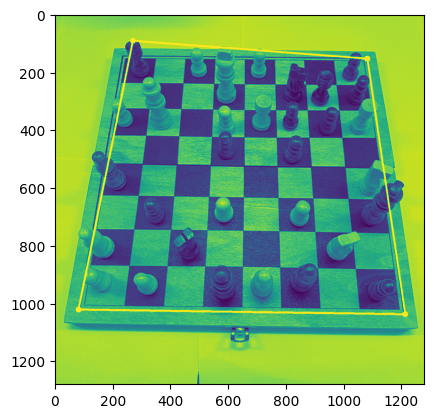

In [9]:
i = 4
while i > 0:
    c = i % 4
    print(c)
    print(point_corners[c])
    cv.line(img_gray, point_corners[c], point_corners[c-1], color = 255, thickness=5)
    i -=1
    
plt.imshow(img_gray)

In [10]:
def split_line(points1, points2, nb):
    x = np.linspace(points1[0],points2[0],nb)
    y = (points2[1]-points1[1])/(points2[0]-points1[0])*(x-points1[0]) + points1[1]
    return x, y

0
3
2
1


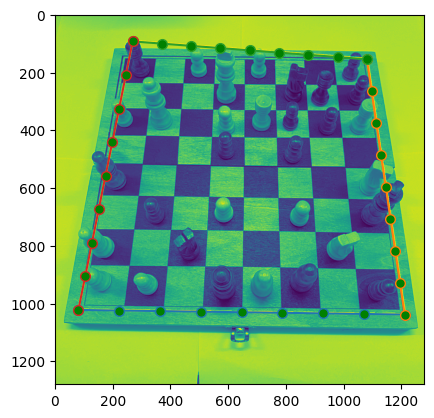

In [11]:
i = 4
while i > 0:
    c = i % 4
    print(c)
    x1, y1 = split_line(point_corners[c], point_corners[c-1], 9)
    plt.plot(x1,y1, marker="o", markersize=7, markerfacecolor="green")
    i -= 1
plt.imshow(img_gray)

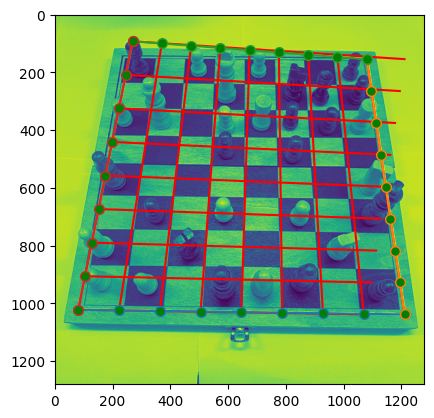

In [12]:
def line_btw_point(points1_1, points1_2, points2_1, points2_2):
    x_1, y_1 = split_line(points1_1, points1_2, 9)
    x_2, y_2 = split_line(points2_1, points2_2, 9)
    x_1 = np.sort(np.array(x_1))
    x_2 = np.sort(np.array(x_2))

    for i in range(len(x_1)):
        x = [x_1[i], x_2[i]]
        y = [y_1[i], y_2[i]]
        plt.plot(x,y, "r")
        ax = plt.gca()
        ax.set_xlim([0, 1280])
        ax.set_ylim([1280, 0])

line_btw_point(point_corners[0], point_corners[1], point_corners[3], point_corners[2])
line_btw_point(point_corners[0], point_corners[3], point_corners[1], point_corners[2])

i = 4
while i > 0:
    c = i % 4
    x1, y1 = split_line(point_corners[c], point_corners[c-1], 9)
    plt.plot(x1,y1, marker="o", markersize=7, markerfacecolor="green")
    i -= 1
    
plt.imshow(img_gray)

670.947021484375 584.2874755859375
1150.1680908203125 947.0675048828125
[[  71 1026]
 [ 121   80]
 [1270  142]
 [1220 1087]]


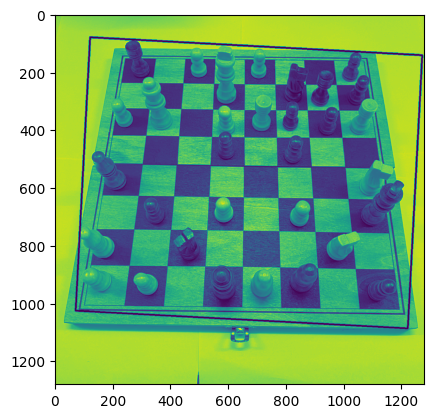

In [13]:
rotatedRect = cv.minAreaRect(contours[real_one])
(x, y), (width, height), angle = rotatedRect
rotatedRectPts = cv.boxPoints(rotatedRect)
rotatedRectPts = np.int0(rotatedRectPts)
top = rotatedRectPts[1]
bottom = rotatedRectPts[3]
print(x,y)
print(width, height)
print(rotatedRectPts)

out = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
cv.drawContours(out, [rotatedRectPts], 0, (0, 255, 0), 5)
plt.imshow(out)

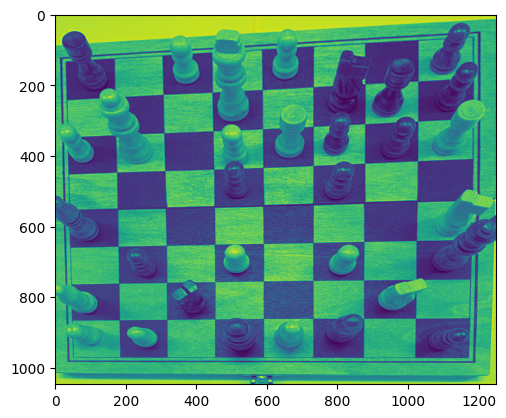

In [14]:
# bottom-left, Top-left, top-right, bottom-right
dstPts = [[0, height], [0, 0], [width, 0], [width, height]]
# Get the transform
m = cv.getPerspectiveTransform(np.float32(point_corners), np.float32(dstPts))

#add padding
padding = 50
m[0,2] += padding
m[1,2] += padding

# Transform the image
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
out = cv.warpPerspective(img_gray, m, (int(width+ 2*padding), int(height+ 2*padding)))
plt.imshow(out)

### Hough lines method

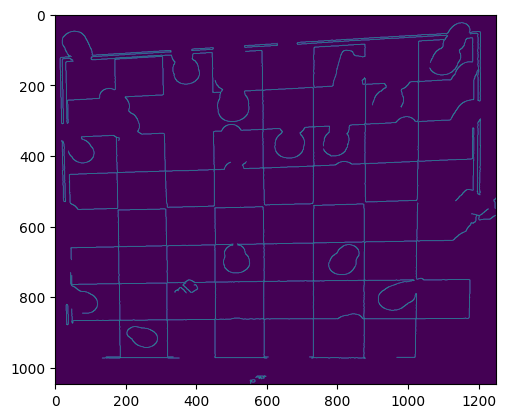

In [15]:
thres = cv.threshold(out,140,255,cv.THRESH_BINARY)
blur = cv.blur(out,(3,3),0)
edges_s = cv.Canny(blur, 170, 500) #70,250 for old
plt.imshow(edges_s)

In [391]:
img_gray_2 = out.copy()
lines = cv.HoughLines(edges_s, 1, np.pi/180, 170)

In [602]:
cart_equ = []
verticality = []
if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1500*(-b)), int(y0 + 1500*(a)))
            pt2 = (int(x0 - 1500*(-b)), int(y0 - 1500*(a)))
            cv.line(img_gray_2, pt1, pt2, (0,0,152), 3, cv.LINE_AA)
            if b != 0:
                cart_equ.append(((-a/b), (rho/b)))
            else: verticality.append(rho)

In [603]:
cart_equ

[(-0.017455041563608085, 660.100536239852),
 (4.371139000186246e-08, 862.0000000000009),
 (-0.017455041563608085, 766.1166829692827),
 (4.371139000186246e-08, 972.000000000001),
 (-0.03492076648448904, 455.27734260821086),
 (57.289790447031756, -9568.852395929414),
 (57.289790447031756, -25325.94466467546),
 (-0.05240779668099624, 245.33622499257265),
 (-0.05240779668099624, 357.48992784632014),
 (-0.0699268498320731, 128.3125632926906),
 (57.289790447031756, -17304.1522369502),
 (-57.28996207463862, 59246.84436640208),
 (-0.0699268498320731, 136.33209849848376),
 (57.289790447031756, -17418.74927163199),
 (-0.05240779668099624, 121.16605397592363),
 (-0.05240779668099624, 118.16193693519826),
 (57.289790447031756, -33405.03560974161),
 (57.289790447031756, -1031.3733121361047),
 (-0.03492076648448904, 561.3419542927611)]

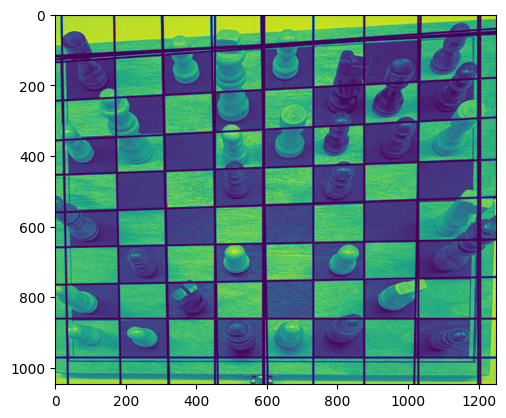

In [604]:
plt.imshow(img_gray_2)

## Hough lines conversion

### cartesian conversion

In [697]:
cart = pd.DataFrame(cart_equ).sort_values(by=1)
x_ca = cart[0]
y_ca = cart[1]

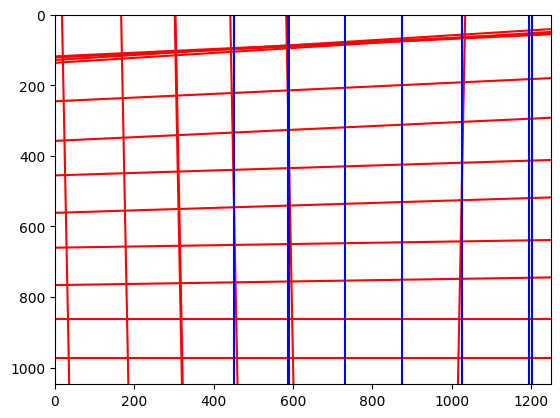

In [698]:
x = np.linspace(0,out.shape[1],len(x_ca))
for i in range(len(x_ca)):
    y = x_ca[i] * x + y_ca[i]
    plt.plot(x, y, '-r', label = f"line{i}")
    ax = plt.gca()
    ax.set_xlim([0, out.shape[1]])
    ax.set_ylim([out.shape[0], 0])
for v in verticality:
    ax.axvline(x = v, color = 'b')

### filtering extra line

In [699]:
from sklearn.metrics.pairwise import cosine_similarity

In [700]:
df = pd.DataFrame(lines[:,0,:]).rename(columns={0: "Rho", 1: "Theta"})
df = df.sort_values(by="Rho")

In [701]:
df

Rho     Theta
22  -583.0  3.124139
7   -442.0  3.124139
18  -304.0  3.124139
14  -302.0  3.124139
6   -167.0  3.124139
23   -18.0  3.124139
21   118.0  1.518436
20   121.0  1.518436
13   128.0  1.500983
16   136.0  1.500983
9    245.0  1.518436
11   357.0  1.518436
10   452.0  0.000000
5    455.0  1.535890
24   561.0  1.535890
25   588.0  0.000000
12   591.0  0.000000
0    660.0  1.553343
1    730.0  0.000000
3    766.0  1.553343
2    862.0  1.570796
8    874.0  0.000000
4    972.0  1.570796
17  1027.0  0.000000
15  1034.0  0.017453
26  1196.0  0.000000
19  1202.0  0.000000

In [702]:
df["diff"] = df["Rho"].diff() + 10*np.abs(df["Theta"].diff())
new_lines = df[df["diff"]>8]
new_lines
df

Rho     Theta        diff
22  -583.0  3.124139         NaN
7   -442.0  3.124139  141.000000
18  -304.0  3.124139  138.000000
14  -302.0  3.124139    2.000000
6   -167.0  3.124139  135.000000
23   -18.0  3.124139  149.000000
21   118.0  1.518436  152.057037
20   121.0  1.518436    3.000000
13   128.0  1.500983    7.174533
16   136.0  1.500983    8.000000
9    245.0  1.518436  109.174530
11   357.0  1.518436  112.000000
10   452.0  0.000000  110.184364
5    455.0  1.535890   18.358898
24   561.0  1.535890  106.000000
25   588.0  0.000000   42.358898
12   591.0  0.000000    3.000000
0    660.0  1.553343   84.533432
1    730.0  0.000000   85.533432
3    766.0  1.553343   51.533432
2    862.0  1.570796   96.174530
8    874.0  0.000000   27.707964
4    972.0  1.570796  113.707962
17  1027.0  0.000000   70.707962
15  1034.0  0.017453    7.174533
26  1196.0  0.000000  162.174530
19  1202.0  0.000000    6.000000

In [703]:
new_lines["a"] = new_lines["Theta"].apply(math.cos)
new_lines["b"] = new_lines["Theta"].apply(math.sin)
new_lines["x"] = -new_lines["a"]/new_lines["b"]
new_lines["y"] = new_lines["Rho"]/new_lines["b"]

mask_vert = (new_lines["a"] < 0) & (new_lines["b"] <0.2 )
mask = new_lines.isin([np.inf]).any(axis=1)
vertical_2 = new_lines[mask + mask_vert]
horizontal = new_lines[~(mask + mask_vert)]
horizontal

/tmp/ipykernel_420/3683298155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_lines["a"] = new_lines["Theta"].apply(math.cos)
/tmp/ipykernel_420/3683298155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_lines["b"] = new_lines["Theta"].apply(math.sin)
/tmp/ipykernel_420/3683298155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Rho     Theta        diff             a         b             x  \
21  118.0  1.518436  152.057037  5.233597e-02  0.998630 -5.240780e-02   
9   245.0  1.518436  109.174530  5.233597e-02  0.998630 -5.240780e-02   
11  357.0  1.518436  112.000000  5.233597e-02  0.998630 -5.240780e-02   
5   455.0  1.535890   18.358898  3.489949e-02  0.999391 -3.492077e-02   
24  561.0  1.535890  106.000000  3.489949e-02  0.999391 -3.492077e-02   
0   660.0  1.553343   84.533432  1.745238e-02  0.999848 -1.745504e-02   
3   766.0  1.553343   51.533432  1.745238e-02  0.999848 -1.745504e-02   
2   862.0  1.570796   96.174530 -4.371139e-08  1.000000  4.371139e-08   
4   972.0  1.570796  113.707962 -4.371139e-08  1.000000  4.371139e-08   

             y  
21  118.161937  
9   245.336225  
11  357.489928  
5   455.277343  
24  561.341954  
0   660.100536  
3   766.116683  
2   862.000000  
4   972.000000

In [704]:
mask = new_lines.isin([np.inf]).any(axis=1)
vertical = new_lines.loc[mask]
new_lines = new_lines.loc[~mask]

In [705]:
vertical["x"].replace([np.inf, -np.inf], 0)
#vertical = vertical.drop(columns="y")
pd.concat([vertical, vertical_2])

Rho     Theta        diff         a         b         x             y
10   452.0  0.000000  110.184364  1.000000  0.000000      -inf           inf
25   588.0  0.000000   42.358898  1.000000  0.000000      -inf           inf
1    730.0  0.000000   85.533432  1.000000  0.000000      -inf           inf
8    874.0  0.000000   27.707964  1.000000  0.000000      -inf           inf
17  1027.0  0.000000   70.707962  1.000000  0.000000      -inf           inf
26  1196.0  0.000000  162.174530  1.000000  0.000000      -inf           inf
7   -442.0  3.124139  141.000000 -0.999848  0.017452  57.28979 -2.532594e+04
18  -304.0  3.124139  138.000000 -0.999848  0.017452  57.28979 -1.741875e+04
6   -167.0  3.124139  135.000000 -0.999848  0.017452  57.28979 -9.568852e+03
23   -18.0  3.124139  149.000000 -0.999848  0.017452  57.28979 -1.031373e+03
10   452.0  0.000000  110.184364  1.000000  0.000000      -inf           inf
25   588.0  0.000000   42.358898  1.000000  0.000000      -inf           inf
1    730.0  0.000000   85.533432  1.000000  0.000000      -inf           inf
8    874.0  0.000000   27.707964  1.000000  0.000000      -inf           inf
17  1027.0  0.000000   70.707962  1.000000  0.000000      -inf           inf
26  1196.0  0.000000  162.174530  1.000000  0.000000      -inf           inf

[57.289790447031756, 57.289790447031756, 57.289790447031756, 57.289790447031756, -0.05240779668099624, -0.05240779668099624, -0.05240779668099624, -0.03492076648448904, -0.03492076648448904, -0.017455041563608085, -0.017455041563608085, 4.371139000186246e-08, 4.371139000186246e-08]


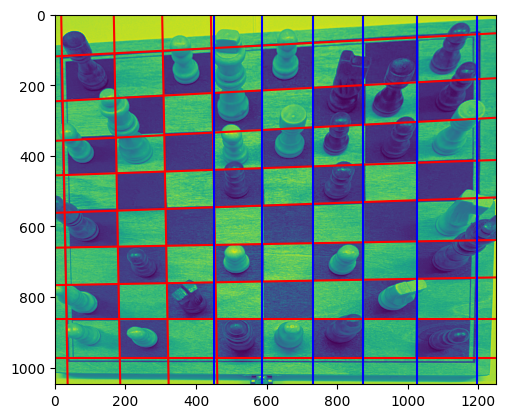

In [706]:
x = np.linspace(0,out.shape[1],len(new_lines))
x_c = new_lines["x"].tolist()
y_c = new_lines["y"].tolist()
print(x_c)
for i in range(len(x_c)):
    y = x_c[i] * x + y_c[i]
    plt.plot(x, y, '-r', label = f"line{i}")
    ax = plt.gca()
    ax.set_xlim([0, out.shape[1]])
    ax.set_ylim([out.shape[0], 0])

vert = vertical["Rho"].tolist()
for v in vert:
    plt.axvline(x = v, color = 'b')
plt.imshow(out)

### Line split method

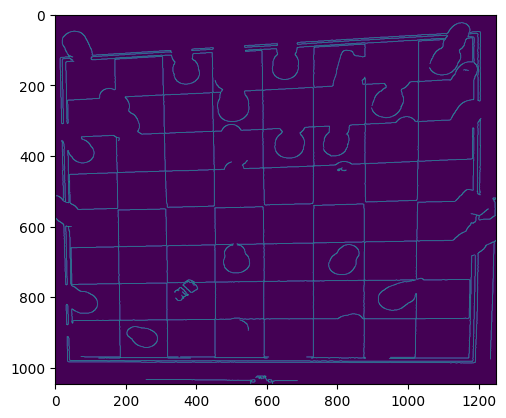

In [690]:
thres_2 = cv.threshold(out,140,255,cv.THRESH_BINARY)
blur_2 = cv.blur(out,(3,3),0)
edges_2 = cv.Canny(blur_2, 150, 400) #70,250 for old
plt.imshow(edges_2)

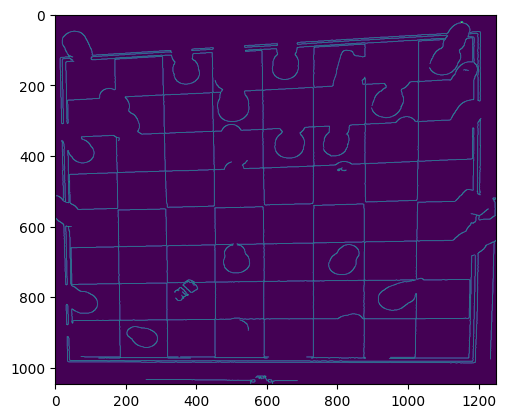

In [692]:
img_test = edges_2.copy()
img_black_test = np.zeros((1280, 1280, 3), dtype = np.uint8)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
dilated_test = cv.dilate(edges_s, kernel, iterations=2)

contours_test, hierarchy = cv.findContours(dilated_test, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

for idx, contour in enumerate (contours_test):
    # Approximate the contour shape to a polygon
    peri = cv.arcLength(contour, True)
    if peri > 500:
        polygon = cv.approxPolyDP(contour, epsilon=0.05*cv.arcLength(contour, True), closed=False)
        sides = len(polygon)
        if sides == 3:
            pass
            #cv.drawContours(img_black_test, [polygon], 0, (0, 255, 0), 2)
        elif sides == 4:
            cv.drawContours(img_test, [polygon], 0, (0, 0, 255), 2)
        else:
            real_one = idx
            cv.drawContours(img_test, [polygon], 0, (255, 0, 0), 2)
plt.imshow(img_test)

### intersections

In [81]:
def intersection(line1, line2):
    x0 = (line2[1] - line1[1]) / (line1[0] - line2[0])
    y0 = line1[0] * x0 + line1[1]
    return x0, y0

In [615]:
total_lines = pd.concat([new_lines, vertical])
total_lines

Rho     Theta        diff             a         b             x  \
7   -442.0  3.124139  141.000000 -9.998477e-01  0.017452  5.728979e+01   
18  -304.0  3.124139  138.000000 -9.998477e-01  0.017452  5.728979e+01   
6   -167.0  3.124139  135.000000 -9.998477e-01  0.017452  5.728979e+01   
23   -18.0  3.124139  149.000000 -9.998477e-01  0.017452  5.728979e+01   
21   118.0  1.518436  152.057037  5.233597e-02  0.998630 -5.240780e-02   
9    245.0  1.518436  109.174530  5.233597e-02  0.998630 -5.240780e-02   
11   357.0  1.518436  112.000000  5.233597e-02  0.998630 -5.240780e-02   
5    455.0  1.535890   18.358898  3.489949e-02  0.999391 -3.492077e-02   
24   561.0  1.535890  106.000000  3.489949e-02  0.999391 -3.492077e-02   
0    660.0  1.553343   84.533432  1.745238e-02  0.999848 -1.745504e-02   
3    766.0  1.553343   51.533432  1.745238e-02  0.999848 -1.745504e-02   
2    862.0  1.570796   96.174530 -4.371139e-08  1.000000  4.371139e-08   
4    972.0  1.570796  113.707962 -4.371139e-08  1.000000  4.371139e-08   
10   452.0  0.000000  110.184364  1.000000e+00  0.000000          -inf   
25   588.0  0.000000   42.358898  1.000000e+00  0.000000          -inf   
1    730.0  0.000000   85.533432  1.000000e+00  0.000000          -inf   
8    874.0  0.000000   27.707964  1.000000e+00  0.000000          -inf   
17  1027.0  0.000000   70.707962  1.000000e+00  0.000000          -inf   
26  1196.0  0.000000  162.174530  1.000000e+00  0.000000          -inf   

               y  
7  -2.532594e+04  
18 -1.741875e+04  
6  -9.568852e+03  
23 -1.031373e+03  
21  1.181619e+02  
9   2.453362e+02  
11  3.574899e+02  
5   4.552773e+02  
24  5.613420e+02  
0   6.601005e+02  
3   7.661167e+02  
2   8.620000e+02  
4   9.720000e+02  
10           inf  
25           inf  
1            inf  
8            inf  
17           inf  
26           inf

In [24]:
intersections = []


In [25]:
intersections_p = []
for x1,y1 in zip(x_ca, y_ca):
    for x2,y2 in zip(x_ca, y_ca):
        line1 = (x1, y1)
        line2 = (x2, y2)
        if line1 != line2:
            if line1[0] - line2[0] != 0:
                x0, y0 = intersection(line1, line2)
                intersections_p.append((round(x0,0), round(y0,0)))

In [26]:
intersections_pd = pd.DataFrame(intersections_p)
intersections_pd = intersections_pd[intersections_pd>0][intersections_pd<1281].dropna().drop_duplicates().reset_index()
x_in = intersections_pd[0].to_list()
y_in = intersections_pd[1].to_list()

### ploting from the list

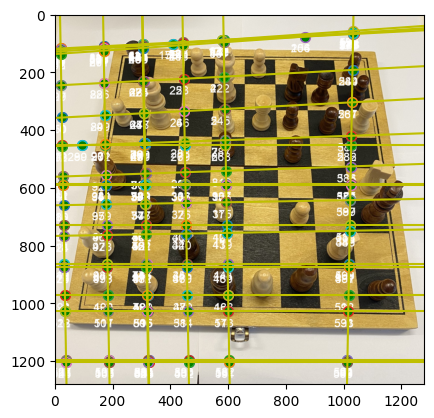

In [27]:
fig = plt.figure()
x = np.linspace(0,1280)
i = 0
img_2 = Image.open(img_path)

for inter in intersections_p:
    text = f"{i}"
    x1 = inter[0]
    y1 = inter[1]
    plt.plot(x1,y1, marker="o", markersize=7, markerfacecolor="green")
    ax = plt.gca()
    ax.set_xlim([0, 1280])
    ax.set_ylim([1280, 0])
    draw = ImageDraw.Draw(img_2)
    font_type = ImageFont.truetype("arial.ttf", 40)
    draw.text((x1-50,y1+20),text, font=font_type)
    i += 1

for coor in cart_equ:
    y2 = coor[0] * x + coor[1]
    plt.plot(x, y2, "y")
    ax = plt.gca()
    ax.set_xlim([0, 1280])
    ax.set_ylim([1280, 0])
plt.imshow(img_2)

### plotting from DataFrame

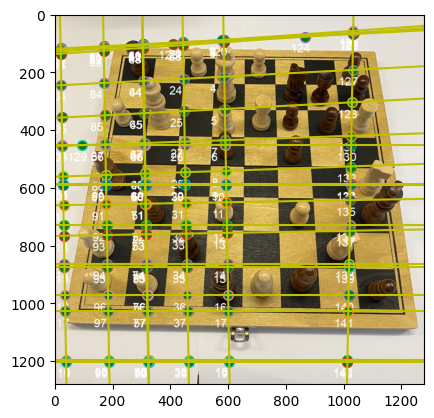

In [28]:
fig = plt.figure()
x = np.linspace(0,1280)
i = 0
img_2 = Image.open(img_path)

for i in range(len(x_in)):
    text = f"{i}"
    x1 = x_in[i]
    y1 = y_in[i]
    plt.plot(x1,y1, marker="o", markersize=7, markerfacecolor="green")
    ax = plt.gca()
    ax.set_xlim([0, 1280])
    ax.set_ylim([1280, 0])
    draw = ImageDraw.Draw(img_2)
    font_type = ImageFont.truetype("arial.ttf", 40)
    draw.text((x1-50,y1+20),text, font=font_type)

for coor in cart_equ:
    y2 = coor[0] * x + coor[1]
    plt.plot(x, y2, "y")
    ax = plt.gca()
    ax.set_xlim([0, 1280])
    ax.set_ylim([1280, 0])
plt.imshow(img_2)

## Coordinate generation

In [29]:
intersection_pd = intersections_pd.drop(columns="index")

In [30]:
A0 = intersection_pd.loc[9].to_list()

In [31]:
coordinate = {}
letters = ["A", "B", "C", "D", "E", "F", "G", "H"]
i = 1
for col in letters:
    for line in range(8):
        val = intersection_pd.loc[9-i + 11*line].to_list()
        text = f"{col}{line}"
        coordinate[text] = val
    i += 1
coordinate

{'A0': [593.0, 541.0],
 'A1': [604.0, 1202.0],
 'A2': [452.0, 591.0],
 'A3': [306.0, 105.0],
 'A4': [317.0, 730.0],
 'A5': [304.0, 115.0],
 'A6': [317.0, 862.0],
 'A7': [173.0, 348.0],
 'B0': [591.0, 435.0],
 'B1': [604.0, 1196.0],
 'B2': [452.0, 588.0],
 'B3': [306.0, 102.0],
 'B4': [315.0, 655.0],
 'B5': [304.0, 107.0],
 'B6': [315.0, 761.0],
 'B7': [171.0, 236.0],
 'C0': [591.0, 452.0],
 'C1': [601.0, 1027.0],
 'C2': [452.0, 546.0],
 'C3': [463.0, 1202.0],
 'C4': [314.0, 591.0],
 'C5': [304.0, 105.0],
 'C6': [315.0, 730.0],
 'C7': [169.0, 125.0],
 'D0': [589.0, 327.0],
 'D1': [600.0, 972.0],
 'D2': [450.0, 440.0],
 'D3': [463.0, 1196.0],
 'D4': [314.0, 588.0],
 'D5': [304.0, 102.0],
 'D6': [313.0, 655.0],
 'D7': [169.0, 116.0],
 'E0': [587.0, 215.0],
 'E1': [598.0, 874.0],
 'E2': [450.0, 452.0],
 'E3': [460.0, 1027.0],
 'E4': [314.0, 550.0],
 'E5': [325.0, 1202.0],
 'E6': [312.0, 591.0],
 'E7': [169.0, 112.0],
 'F0': [585.0, 95.0],
 'F1': [598.0, 862.0],
 'F2': [448.0, 334.0],
 'F3'

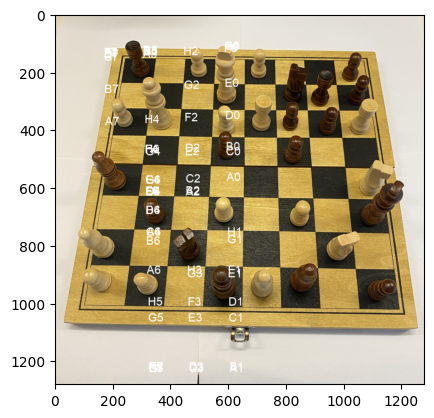

In [32]:
img_3 = Image.open(img_path)
for key, value in coordinate.items():
    text = key
    draw = ImageDraw.Draw(img_3)
    font_type = ImageFont.truetype("arial.ttf", 40)
    draw.text(value,text, font=font_type)
plt.imshow(img_3)

## Colour detection

In [33]:
def pix_val(img, coor):
    return img.getpixel(coor)

In [34]:
def detect_colour(val):
    if val > 125:
        return "White"
    else: return "Black"

In [35]:
img_color = Image.open(img_path)
img_gray_pil = ImageOps.grayscale(img_color)

In [36]:
pick_A0 = (coordinate["A0"][0]+5, coordinate["A0"][1]+3)
pick_A7 = (coordinate["A7"][0]+5, coordinate["A7"][1]+3)
pick_H0 = (coordinate["H0"][0]+5, coordinate["H0"][1]+3)
pick_H7 = (coordinate["H7"][0]+5, coordinate["H7"][1]+3)

points = [pick_A0, pick_A7, pick_H0, pick_H7]

In [37]:
points[0]

(598.0, 544.0)

In [38]:
for point in points:
    text = detect_colour(pix_val(img_gray_pil, point))
    draw = ImageDraw.Draw(img_gray_pil)
    font_type = ImageFont.truetype("arial.ttf", 40)
    draw.text(point,text, font=font_type, fill=255)

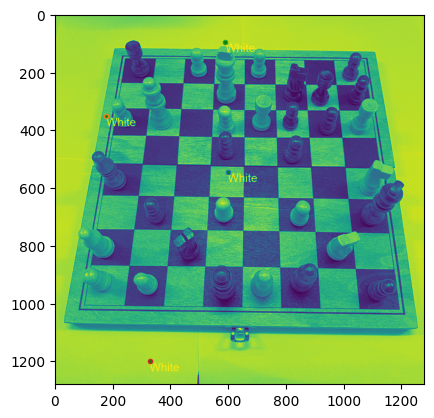

In [39]:
plt.plot(pick_A0[0],pick_A0[1], marker="o", markersize=3, markerfacecolor="green")
plt.plot(pick_A7[0],pick_A7[1], marker="o", markersize=3, markerfacecolor="green")
plt.plot(pick_H0[0],pick_H0[1], marker="o", markersize=3, markerfacecolor="green")
plt.plot(pick_H7[0],pick_H7[1], marker="o", markersize=3, markerfacecolor="green")
plt.imshow(img_gray_pil)